# Significance of community structure

In network analysis, finding communities is often just the first step. The next, and arguably more critical, question is whether the detected community structure is truly significant or if it's simply a random artifact of the network's size and density.

This notebook addresses that question directly. We will explore a powerful statistical method for assessing the significance of community structure by comparing our network's modularity to a null model. By generating and analyzing a large number of randomized networks, we can determine whether the communities we found are genuinely meaningful or if similar structures could have easily arisen by chance.

The goal is to move beyond mere detection and gain confidence in our results, ensuring that our insights into the network's organization are robust and reliable.

---

There are multiple methods that we can use to test if a network has a significant community
structure. These methods are complementary and sometimes we need to use more than one
to gain confidence in our result.

In [1]:
import igraph as ig
import numpy as np
import random
ig.config["plotting.backend"] = "matplotlib"

In [2]:
%run -i functions.ipynb

## Method 1: Testing network structure with modularity 

__Idea__: Compare to a null model.
- Find communities in our network and measure the modularity.
- Randomize the network, by rewiring, while keeping some property (typically the degrees) fixed. Detect communities again. Did the modularity drop? If yes, then the original network has a significantly high modularity score.

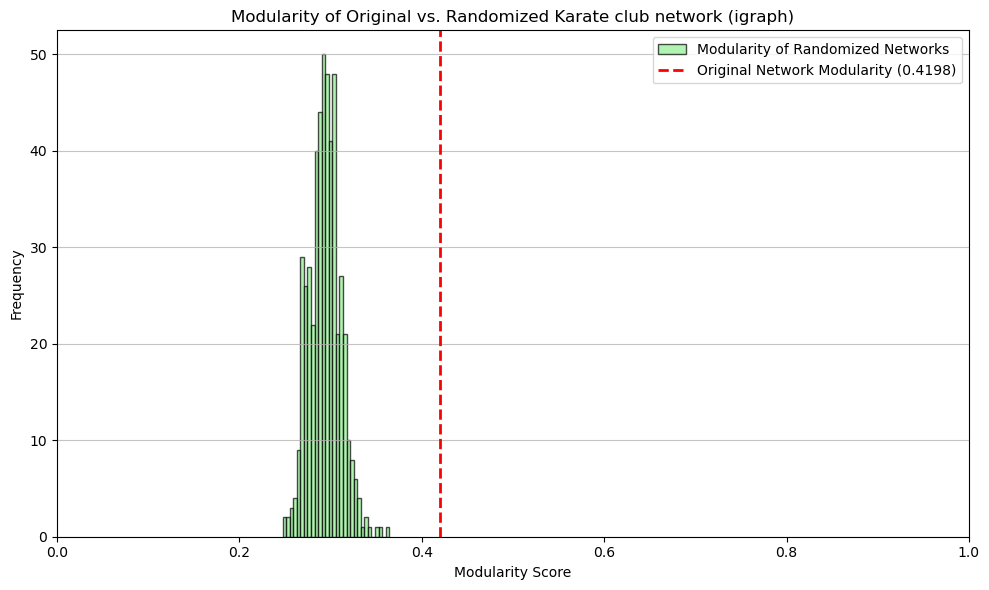

In [3]:
karate_club = ig.Graph.Famous("Zachary")

test_community_structure(karate_club, graph_name="Karate club network")

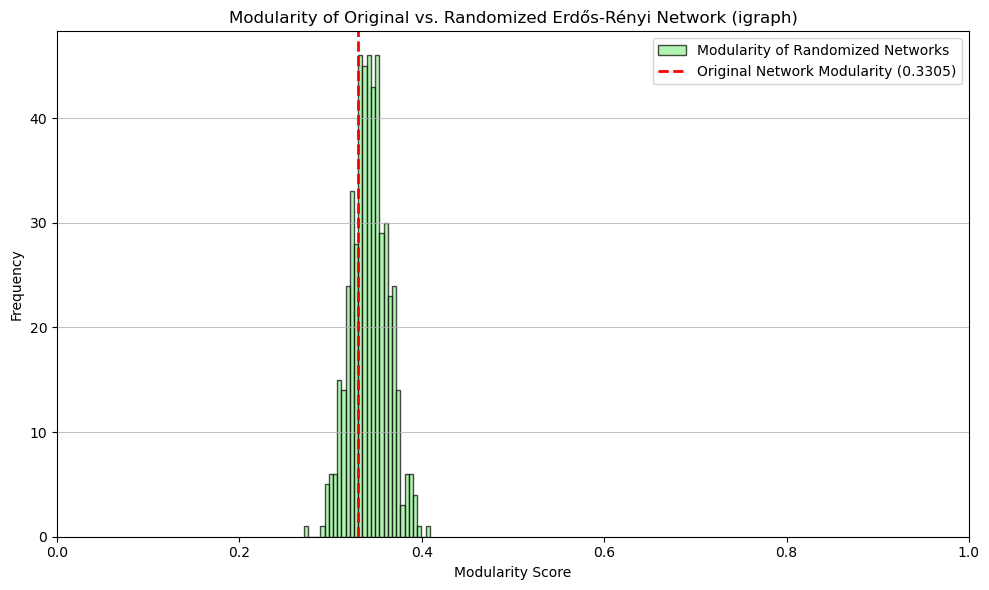

In [4]:
num_nodes = karate_club.vcount()
num_edges = karate_club.ecount()

er_graph = ig.Graph.Erdos_Renyi(n=num_nodes, m=num_edges)

test_community_structure(er_graph, graph_name="Erdős-Rényi Network")

## Method 2: Testing network structure with NMI values
__Idea__: Do we get consistent results across different tries?

Let’s use a stochastic community detection algorithm like Leiden method, run it 100 times to obtain 100 different groupings/partitionings, and compare the partitionings. Does the method tend to return roughly the same result? To answer this question, we will use a measure called “normalized mutual information” to compare partitionings to each other, pairwise. A value of 1 means that the two partitions are identical, a high value (close to 1) means that they are similar, a low value means that they are dissimilar.

### Pairwise comparisons

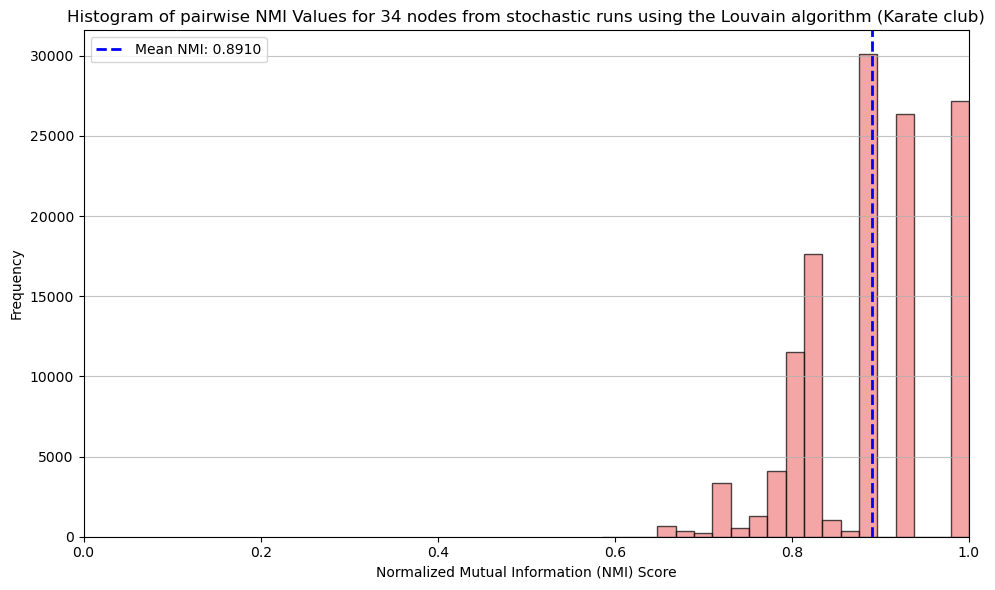

In [5]:
title = f'Histogram of pairwise NMI Values for {karate_club.vcount()} nodes from stochastic runs using the Louvain algorithm (Karate club)'
all_partitions = run_stochastic_community_detection(karate_club, None, 500, community_detection_method="multilevel", return_partitions=True)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(karate_club, pairwise_nmi_values, title)

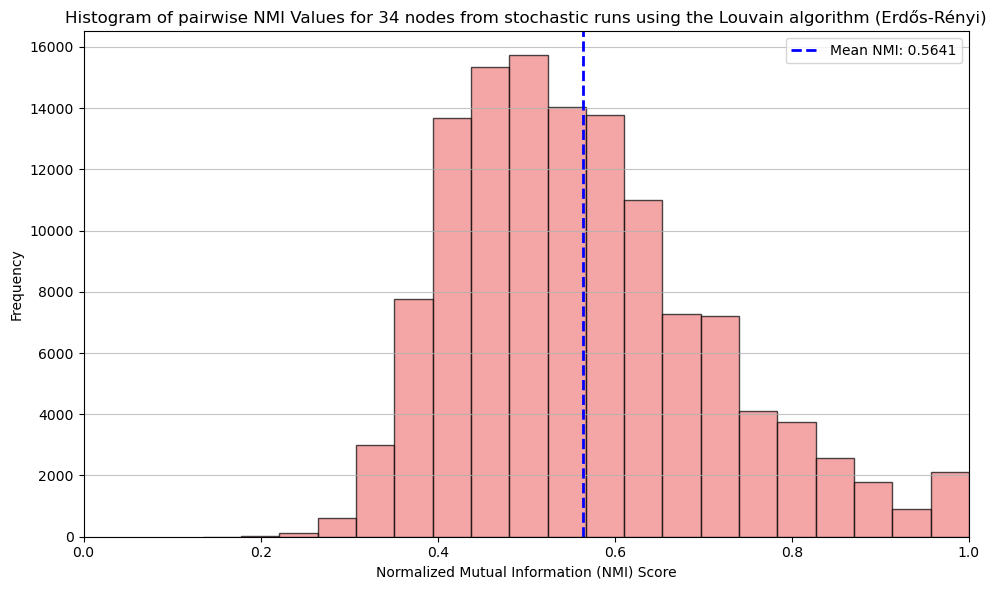

In [6]:
title = f'Histogram of pairwise NMI Values for {er_graph.vcount()} nodes from stochastic runs using the Louvain algorithm (Erdős-Rényi)'
all_partitions = run_stochastic_community_detection(er_graph, None, 500, community_detection_method="multilevel", return_partitions=True)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(er_graph, pairwise_nmi_values, title)

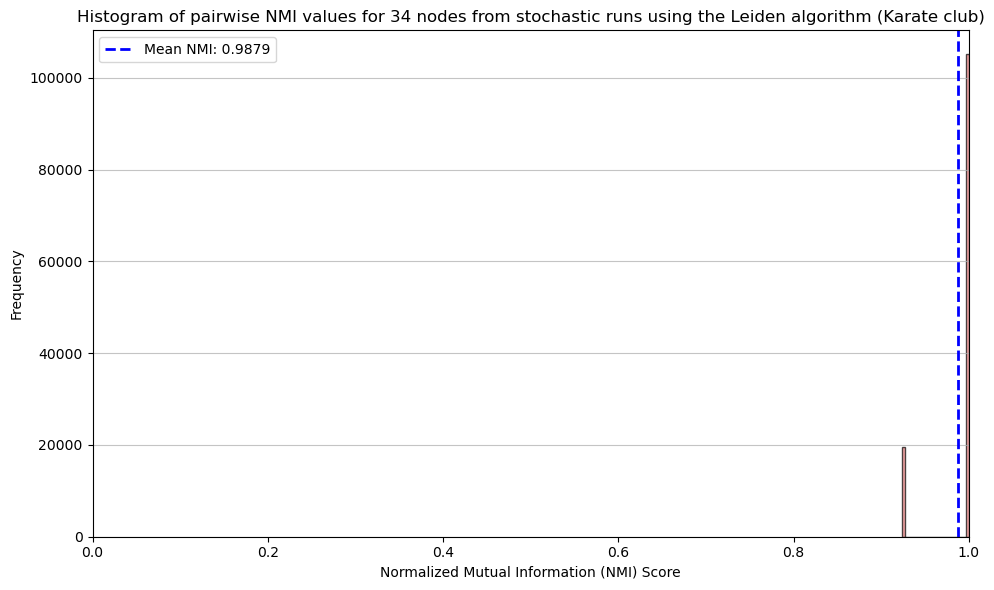

In [7]:
num_runs = 500
params = {
    "objective_function": "modularity",
    "resolution": np.ones(num_runs),
}
title = f'Histogram of pairwise NMI values for {karate_club.vcount()} nodes from stochastic runs using the Leiden algorithm (Karate club)'
all_partitions = run_stochastic_community_detection(karate_club, None, num_runs, community_detection_method="leiden", 
                                                    return_partitions=True, params=params)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(karate_club, pairwise_nmi_values, title)

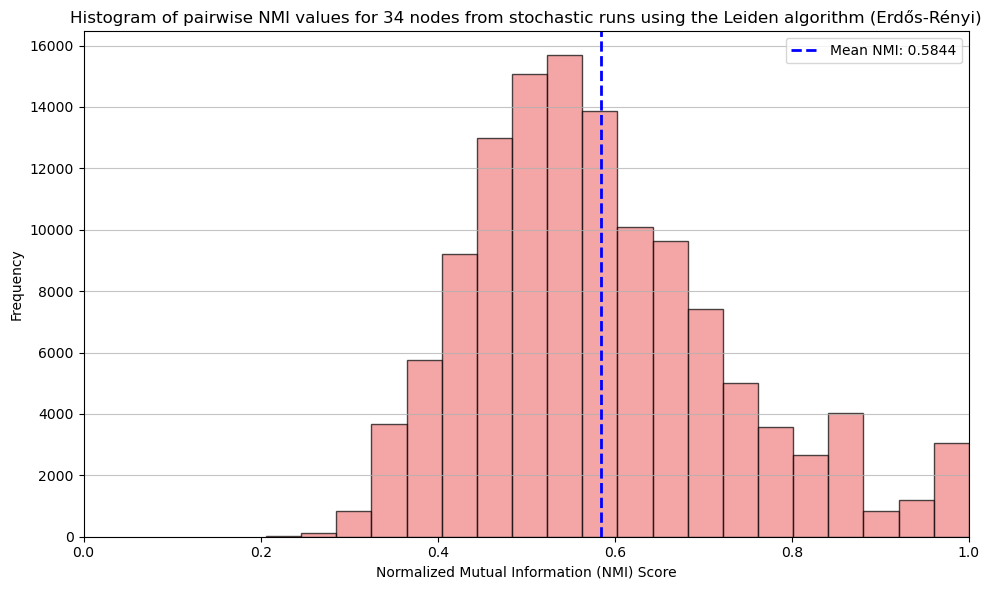

In [8]:
num_runs = 500
params = {
    "objective_function": "modularity",
    "resolution": np.ones(num_runs),
}
title = f'Histogram of pairwise NMI values for {er_graph.vcount()} nodes from stochastic runs using the Leiden algorithm (Erdős-Rényi)'
all_partitions = run_stochastic_community_detection(er_graph, None, num_runs, community_detection_method="leiden", 
                                                    return_partitions=True, params=params)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(er_graph, pairwise_nmi_values, title)

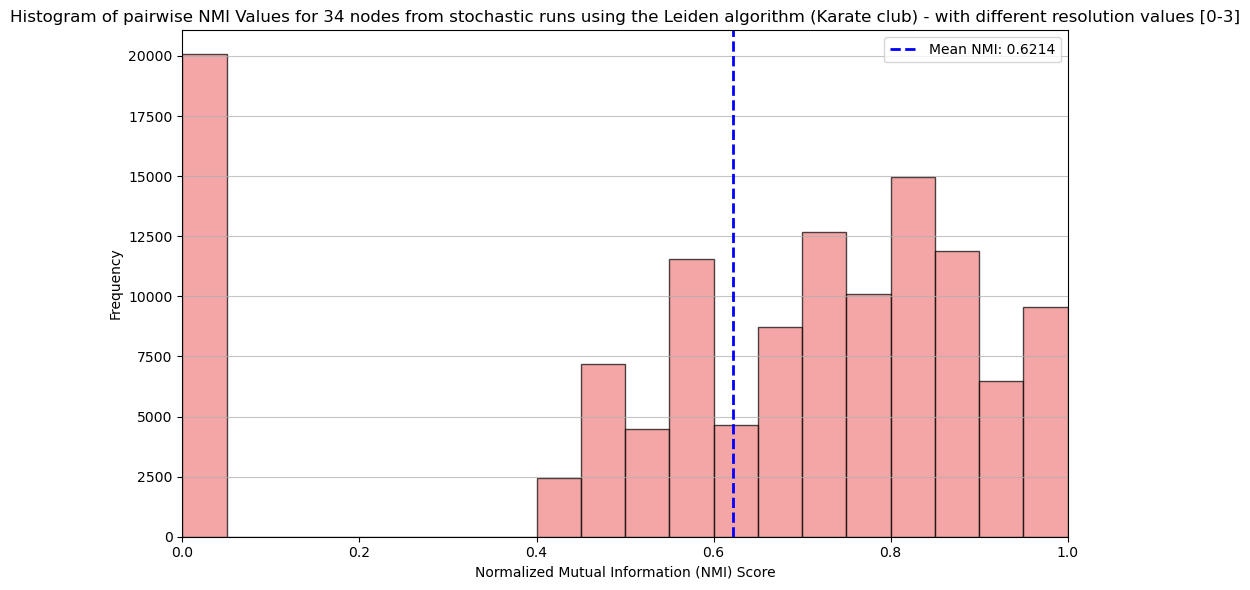

In [9]:
params = {
    "objective_function": "modularity",
    "resolution": [random.uniform(0., 3.) for _ in range(num_runs)]
}
title = f'Histogram of pairwise NMI Values for {karate_club.vcount()} nodes from stochastic runs using the Leiden algorithm (Karate club) - with different resolution values [0-3]'
all_partitions = run_stochastic_community_detection(karate_club, None, num_runs, community_detection_method="leiden", 
                                                    return_partitions=True, params=params)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(karate_club, pairwise_nmi_values, title)

## Testing significance of community structure on a grid graph

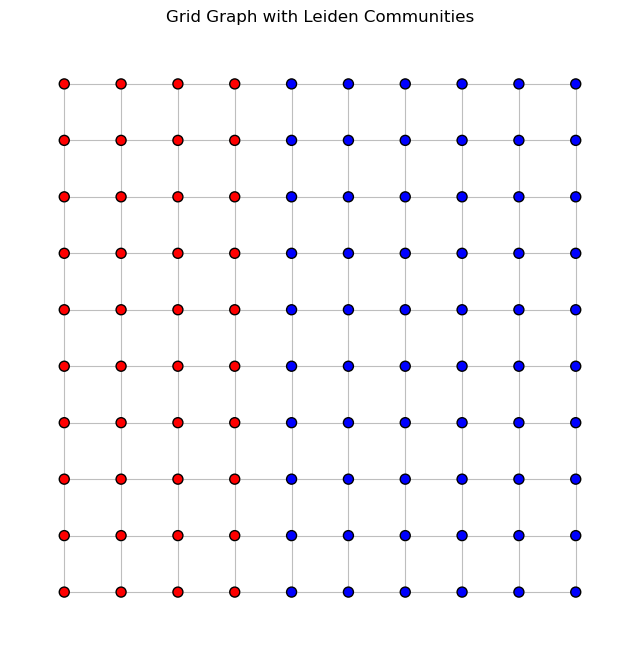

In [10]:
grid_cols = 10
grid_graph = ig.Graph.Lattice(dim=[grid_cols, grid_cols], nei=1, circular=False)
random.seed(13)

# Clustering
resolution = 0.15
communities = grid_graph.community_leiden(objective_function="modularity", resolution=resolution)

plot_leiden_on_grid(grid_graph, grid_cols, communities, title="Grid Graph with Leiden Communities", plot_size=(8, 8))

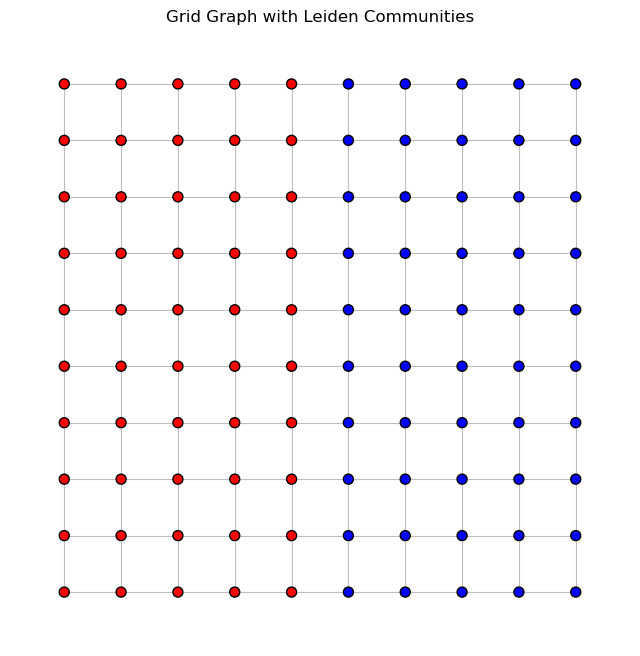

In [11]:
random.seed(44)

# Clustering
resolution = 0.15
communities = grid_graph.community_leiden(objective_function="modularity", resolution=resolution)

plot_leiden_on_grid(grid_graph, grid_cols, communities, title="Grid Graph with Leiden Communities", plot_size=(8, 8))

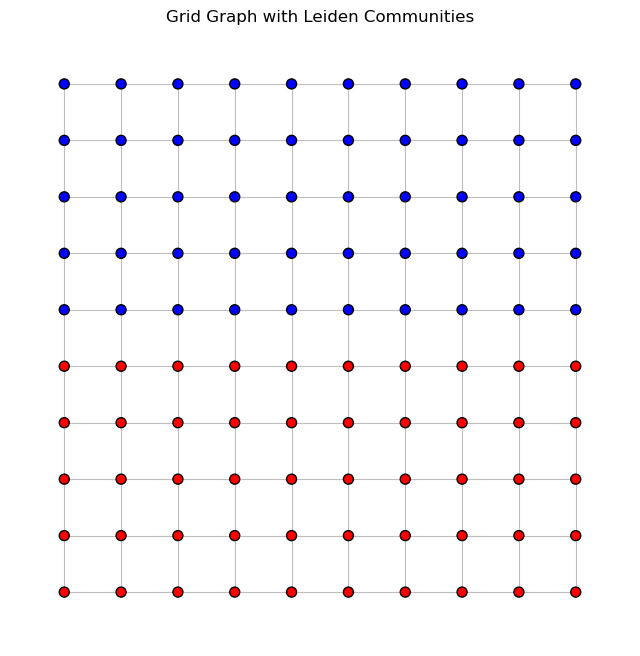

In [12]:
random.seed(60)

# Clustering
resolution = 0.15
communities = grid_graph.community_leiden(objective_function="modularity", resolution=resolution)

plot_leiden_on_grid(grid_graph, grid_cols, communities, title="Grid Graph with Leiden Communities", plot_size=(8, 8))

_Note:_ The previous plots show that the clustering can produce different outputs. However, one is not necessarily better than the other; their quality is essentially equivalent.

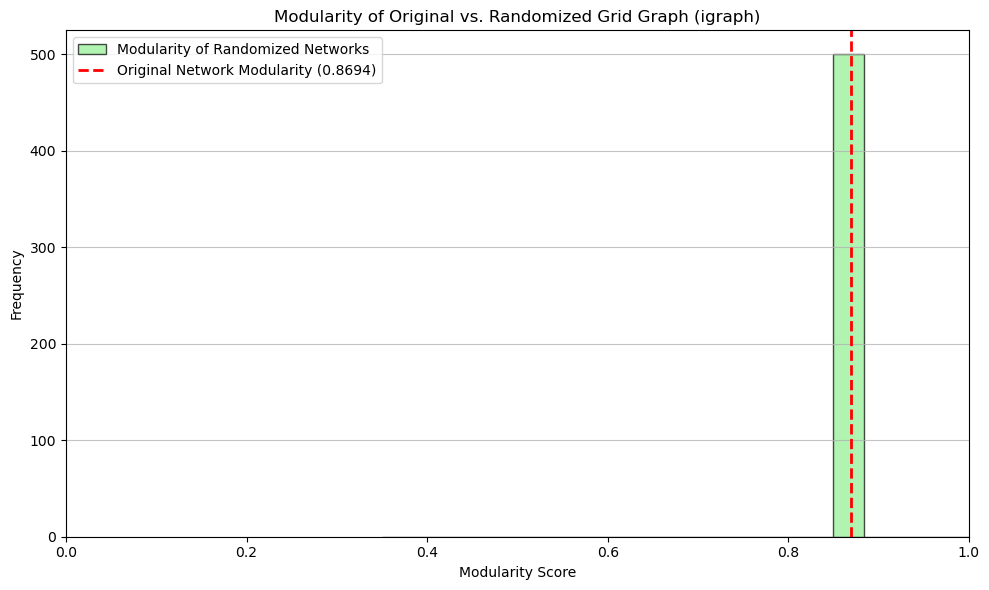

In [13]:
params = {
    "objective_function": "modularity",
    "resolution": 0.15,
}
test_community_structure(grid_graph, graph_name="Grid Graph", community_detection_method="leiden", params=params)

The modularity is significantly higher in both grids than in their randomized versions. This is because after randomization, it is no longer possible to find a grouping in which nodes mostly connect to other nodes within the same group. Yet grids/lattices are homogeneous, so we can’t say that they have a community structure. This is an example of a situation where only _Method 2_ could warn us that the community structure we find may not be valid.

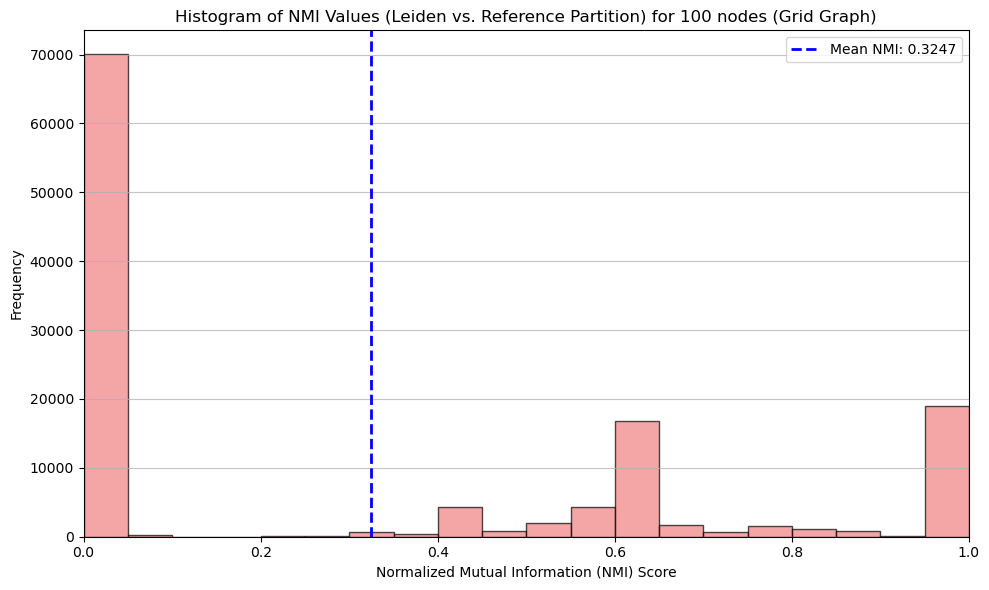

In [14]:
num_runs = 500
params = {
    "objective_function": "modularity",
    "resolution": [resolution for _ in range(num_runs)],
}
title = f'Histogram of NMI Values (Leiden vs. Reference Partition) for {grid_graph.vcount()} nodes (Grid Graph)'
all_partitions = run_stochastic_community_detection(grid_graph, None, num_runs, community_detection_method="leiden", 
                                                    return_partitions=True, params=params)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(er_graph, pairwise_nmi_values, title)